In [14]:
from collections import deque, namedtuple
from gymnasium import spaces
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.distributions import Categorical
import torch.nn.functional as F
import tqdm
import pickle

In [2]:
LOG_LEVEL='info'

## Four Rooms Environment

In [3]:
class FourRooms(object):
    def __init__(self, reward_fn='sparse'):
        # The grid for the Four Rooms domain
        self.grid = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

        # Observation (state) space consists of all empty cells
        # To improve interpretability, we flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        self.observation_space = np.argwhere(self.grid == 0.0).tolist()  # Fine all empty cells
        self.observation_space = self.arr_coords_to_four_room_coords(self.observation_space)

        # Action space
        self.action_movement = {0: np.array([0, 1]),  # up
                                1: np.array([0, -1]),  # down
                                2: np.array([-1, 0]),  # left
                                3: np.array([1, 0])}  # right
        self.action_space = spaces.Discrete(4)

        # Start location
        self.start_location = [0, 0]

        # Goal location
        self.goal_location = [10, 10]

        # Wall locations
        self.walls = np.argwhere(self.grid == 1.0).tolist()  # find all wall cells
        self.walls = self.arr_coords_to_four_room_coords(self.walls)  # convert to Four Rooms coordinates

        # This is an episodic task, with a timeout of 459 steps
        self.max_time_steps = 459

        # Tracking variables during a single episode
        self.agent_location = None  # Track the agent's location in one episode.
        self.action = None  # Track the agent's action
        self.t = 0  # Track the current time step in one episode

        # reward function type
        self.reward_fn = reward_fn

    @staticmethod
    def arr_coords_to_four_room_coords(arr_coords_list):
        """
        Function converts the array coordinates ((row, col), origin is top left)
        to the Four Rooms coordinates ((x, y), origin is bottom left)
        E.g., The coordinates (0, 0) in the numpy array is mapped to (0, 10) in the Four Rooms coordinates.
        Args:
            arr_coords_list (list): List variable consisting of tuples of locations in the numpy array

        Return:
            four_room_coords_list (list): List variable consisting of tuples of converted locations in the
                                          Four Rooms environment.
        """
        # Flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        four_room_coords_list = [(column_idx, 10 - row_idx) for (row_idx, column_idx) in arr_coords_list]
        return four_room_coords_list

    def reset(self):
        # Reset the agent's location to the start location
        self.agent_location = self.start_location

        # Reset the timeout tracker to be 0
        self.t = 0

        # Reset the information
        info = {}
        return self.agent_location, info

    def step(self, action):
        """
        Args:
            action (int): Int variable (i.e., 0 for "up"). See self.action_movement above for more details.
        """
        # With probability 0.8, the agent takes the correct direction.
        # With probability 0.2, the agent takes one of the two perpendicular actions.
        # For example, if the correct action is "LEFT", then
        #     - With probability 0.8, the agent takes action "LEFT";
        #     - With probability 0.1, the agent takes action "UP";
        #     - With probability 0.1, the agent takes action "DOWN".
        if np.random.uniform() < 0.2:
            if action == 2 or action == 3:
                action = np.random.choice([0, 1], 1)[0]
            else:
                action = np.random.choice([2, 3], 1)[0]

        # Convert the agent's location to array
        loc_arr = np.array(self.agent_location)

        # Convert the action name to movement array
        act_arr = self.action_movement[action]

        # Compute the agent's next location
        next_agent_location = np.clip(loc_arr + act_arr,
                                      a_min=np.array([0, 0]),
                                      a_max=np.array([10, 10])).tolist()

        # Check if the agent crashes into walls; if so, it stays at the current location.
        if tuple(next_agent_location) in self.walls:
            next_agent_location = self.agent_location

        # Compute the reward (1 iff next state is goal location)
        if self.reward_fn == 'dense':
            reward = 0.0 if next_agent_location == self.goal_location else -1.0
        elif self.reward_fn == 'manhattan':
            manhattan_dist = np.abs(np.array(next_agent_location) - np.array(self.goal_location)).sum()
            reward = -manhattan_dist
        else:
            reward = 1.0 if next_agent_location == self.goal_location else 0.0

        # Check termination/truncation
        # If agent reaches the goal, reward = 1, terminated = True
        # If timeout is reached, reward = 0, truncated = True
        terminated = False
        truncated = False
        if reward == 1.0:
            terminated = True
        elif self.t == self.max_time_steps:
            truncated = True

        # Update the agent's location, action, and time step trackers
        self.agent_location = next_agent_location
        self.action = action
        self.t += 1

        return next_agent_location, reward, terminated, truncated, {}

    def render(self):
        # Plot the agent and the goal
        # empty cell = 0
        # wall cell = 1
        # agent cell = 2
        # goal cell = 3
        plot_arr = self.grid.copy()
        plot_arr[10 - self.agent_location[1], self.agent_location[0]] = 2
        plot_arr[10 - self.goal_location[1], self.goal_location[0]] = 3
        plt.clf()
        plt.title(f"state={self.agent_location}, act={self.action_movement[self.action]}")
        plt.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(0.1)

    @staticmethod
    def test():
        env = FourRooms()
        state, info = env.reset()

        for _ in range(1000):
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, info = env.step(action)
            env.render()
            if terminated or truncated:
                state, info = env.reset()
            else:
                state = next_state

# Un-comment to run test function
# FourRooms.test()

In [4]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

In [5]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title, smoothing = True):
    """
    Args:
        arr_list (list): List of results arrays to plot
        legend_list (list): List of legends corresponding to each result array
        color_list (list): List of color corresponding to each result array
        ylabel (string): Label of the vertical axis

        Make sure the elements in the arr_list, legend_list, and color_list
        are associated with each other correctly (in the same order).
        Do not forget to change the ylabel for different plots.
    """
    # Set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the vertical labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # Plot results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # Compute the standard error (of raw data, not smoothed)
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # Plot the mean
        averages = moving_average(arr.mean(axis=0)) if smoothing else arr.mean(axis=0)
        h, = ax.plot(range(arr.shape[1]), averages, color=color, label=legend)
        # Plot the confidence band
        arr_err *= 1.96
        print(f"{(averages - arr_err).shape=}")
        ax.fill_between(range(arr.shape[1]), averages - arr_err, averages + arr_err, alpha=0.3,
                        color=color)
        # Save the plot handle
        h_list.append(h)

    # Plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

## PPO Implementation

### Actor Critic Networks

In [40]:
# Policy and value networks
class ActorCriticNet(nn.Module):
    def __init__(self, observation_dim=3, hidden_dim=128, n_hidden=1, action_dim=4):
        super(ActorCriticNet, self).__init__()

        """ YOUR CODE HERE:
                Implement the critic network here. The architecture should be:

                Layer 1: Linear, input size 3, output size 128
                Activation 1: ReLU
                Layer 2: Linear, input size 128, output size 1
                Activation 2: Identity (or none)
        """
        self.n_hidden = n_hidden

        self.critic_in = nn.Linear(observation_dim, hidden_dim)
        if n_hidden > 1:
            self.critic_hidden = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim)] * (n_hidden - 1))
        self.relu = nn.ReLU()
        self.critic_out = nn.Linear(hidden_dim, 1)

        """ YOUR CODE HERE:
                Implement the actor network here. The architecture should be (same as before):

                Layer 1: Linear, input size 3, output size 128
                Activation 1: ReLU
                Layer 2: Linear, input size 128, output size 4
                Activation 2: Softmax
        """
        self.actor_in = nn.Linear(observation_dim, hidden_dim)
        if n_hidden > 1:
            self.actor_hidden = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim)] * (n_hidden - 1))
        # reuse self.relu
        self.actor_out = nn.Linear(hidden_dim, action_dim)
        self.softmax = nn.Softmax(dim=-1)

        # create module groups
        if n_hidden > 1:
            self.groups = nn.ModuleDict({
                'actor': nn.ModuleList([self.actor_in, self.actor_hidden, self.actor_out]),
                'critic': nn.ModuleList([self.critic_in, self.critic_hidden, self.critic_out])
            })
        else:
            self.groups = nn.ModuleDict({
                'actor': nn.ModuleList([self.actor_in, self.actor_out]),
                'critic': nn.ModuleList([self.critic_in, self.critic_out])
            })


    def forward(self, x):
        """ YOUR CODE HERE:
                Implement the forward propagation for both actor and critic networks
        """

        critic_x = self.critic_in(x)
        critic_x = self.relu(critic_x)
        if self.critic_hidden is not None:
            for layer in self.critic_hidden:
                critic_x = layer(critic_x)
                critic_x = self.relu(critic_x)

        state_value = self.critic_out(critic_x)

        actor_x = self.actor_in(x)
        actor_x = self.relu(actor_x)
        if self.actor_hidden is not None:
            for layer in self.actor_hidden:
                actor_x = layer(actor_x)
                actor_x = self.relu(actor_x)
        actor_x = self.actor_out(actor_x)
        action_probs = self.softmax(actor_x)

        return state_value, action_probs

In [7]:
class SharedActorCriticNet(nn.Module):
    def __init__(self, observation_dim=3, hidden_dim=128, action_dim=4):
        super(SharedActorCriticNet, self).__init__()

        """ YOUR CODE HERE:
                Implement the critic network here. The architecture should be:

                Layer 1: Linear, input size 3, output size 128
                Activation 1: ReLU
                Layer 2: Linear, input size 128, output size 1
                Activation 2: Identity (or none)
        """
        self.shared_in = nn.Linear(observation_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.critic_out = nn.Linear(hidden_dim, 1)

        """ YOUR CODE HERE:
                Implement the actor network here. The architecture should be (same as before):

                Layer 1: Linear, input size 3, output size 128
                Activation 1: ReLU
                Layer 2: Linear, input size 128, output size 4
                Activation 2: Softmax
        """
        # reuse shared_in, self.relu
        self.actor_out = nn.Linear(hidden_dim, action_dim)
        self.softmax = nn.Softmax(dim=-1)

        # create module groups
        self.groups = nn.ModuleDict({
            'actor': nn.ModuleList([self.shared_in, self.actor_out]),
            'critic': nn.ModuleList([self.shared_in, self.critic_out])
        })


    def forward(self, x):
        """ YOUR CODE HERE:
                Implement the forward propagation for both actor and critic networks
        """
        # shared feature extraction layer
        shared_x = self.shared_in(x)
        shared_x = self.relu(shared_x)

        # Compute state value estimates (critic network)
        state_value = self.critic_out(shared_x)

        # Compute action probabilities (actor network)
        actor_x = self.actor_out(shared_x)
        action_probs = self.softmax(actor_x)

        return state_value, action_probs

In [8]:
import pdb

### PPO Agent

In [41]:
# PPO agent - use joint or separate actor critic networks
class PPOAgent(object):
    def __init__(self, observation_dim=3, hidden_dim=128, n_hidden=1, action_dim=4, shared_backbone=False):
        # Create the actor and critic networks
        if shared_backbone:
            self.policy_net = SharedActorCriticNet(observation_dim, hidden_dim, n_hidden, action_dim)
        else:
            self.policy_net = ActorCriticNet(observation_dim, hidden_dim, n_hidden, action_dim)

    def get_action(self, state):
        # Sample an action from the actor network, return the action and its log probability,
        # and return the state value according to the critic network
        state_tensor = torch.tensor(state).float().view(1, -1)
        state_value, action_probs = self.policy_net(state_tensor)
        m = Categorical(action_probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action.item(), log_prob, state_value

    def evaluate(self, state, action):
        """
        Returns state value estimate and entropy of action distribution at a given state or batch of states
        and log probability of given actions
        """
        # state_tensor = torch.tensor(state).float().view(1, -1)
        state_value, action_probs = self.policy_net(state)
        m = Categorical(action_probs)

        return state_value, m.entropy(), m.log_prob(action)

    def save_model(self, path):
        torch.save(self.policy_net.state_dict(), path)

    def load_model(self, path):
        self.policy_net.load_state_dict(torch.load(path))

    def get_current_log_probs(self, state, action):
        # state_tensor = torch.tensor(state).float().view(1, -1)

        # _, old_action_probs = self.target_net(state_tensor)
        _, current_action_probs = self.policy_net(state)
        if LOG_LEVEL == 'debug':
            print(f"get_action_probability: {current_action_probs.shape=} {action.shape=}")
        # pdb.set_trace()
        m = Categorical(current_action_probs)
        return m.log_prob(action)


### Replay Buffer

In [ ]:
Batch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones', 'log_probs', 'state_values', 'returns')
)


class ReplayMemory:
    def __init__(self, max_size, state_dim):
        """Replay memory implemented as a circular buffer.

        Experiences will be removed in a FIFO manner after reaching maximum
        buffer size.

        Args:
            - max_size: Maximum size of the buffer
            - state_size: Size of the state-space features for the environment
        """
        self.max_size = max_size
        self.state_dim = state_dim

        # Preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_dim))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, state_dim))
        self.dones = torch.empty((max_size, 1), dtype=torch.bool)
        # self.boostrap_returns = torch.empty((max_size, 1))
        self.log_probs = torch.empty((max_size, 1))
        self.state_values = torch.empty((max_size, 1))

        # to store rewards-to-go, computed later
        self.returns = torch.empty((max_size, 1))
        self.returns_computed = False

        # Pointer to the current location in the circular buffer
        self.idx = 0
        # Indicates number of transitions currently stored in the buffer
        self.size = 0

    def add(self, state, action, reward, next_state, done, log_prob, state_value):
        """Add a transition to the buffer.

        :param state: 1-D np.ndarray of state-features
        :param action: Integer action
        :param reward: Float reward
        :param next_state: 1-D np.ndarray of state-features
        :param done: Boolean value indicating the end of an episode
        :param bootstrap_return: reward + critic(s')
        :param log_prob log of probability for selected action
        :param state_value s
        """

        if self.size == self.max_size:
            return

        # YOUR CODE HERE: Store the input values into the appropriate
        # attributes, using the current buffer position `self.idx`

        self.states[self.idx] = torch.tensor(state)
        self.actions[self.idx] = action
        self.rewards[self.idx] = reward
        self.next_states[self.idx] = torch.tensor(next_state)
        self.dones[self.idx] = done

        # self.boostrap_returns[self.idx] = bootstrap_return
        self.log_probs[self.idx] = log_prob
        self.state_values[self.idx] = state_value

        # DO NOT EDIT
        # Circulate the pointer to the next position
        self.idx = (self.idx + 1) % self.max_size
        # Update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def compute_returns(self, gamma):
        G = 0
        returns = deque()
        ep_returns = deque()

        for i in range(self.size - 1, -1, -1):
            reward = self.rewards[i]
            done = self.dones[i]

            if done:
                # end of episode, reset discounted return calculation
                ep_returns.appendleft(G)
                G = 0

            # always detach returns, never take gradient w.r.t return
            G = gamma * G + reward.detach().item()
            self.returns[i] = G

        self.returns_computed = True

        return G, ep_returns

    def get_all(self):
        if not self.returns_computed:
            raise Exception('Returns not yet computed! Please call buffer.compute_returns() before sampling.')

        return Batch(
            self.states[:self.size],
            self.actions[:self.size],
            self.rewards[:self.size],
            self.next_states[:self.size],
            self.dones[:self.size],
            self.log_probs[:self.size],
            self.state_values[:self.size],
            self.returns[:self.size]
        )


    def batches(self, batch_size):
        """Iterate through random batches of sampled transitions.

        :param batch_size: Number of transitions to sample in each batch
        :rtype: Batch
        """

        if not self.returns_computed:
            raise Exception('Returns not yet computed! Please call buffer.compute_returns() before sampling.')

        shuf_indices = torch.randperm(self.size, dtype=torch.long)

        for start_idx in range(0, self.size, batch_size):
            end_idx = start_idx + batch_size

            if end_idx > self.size:
                end_idx = self.size

            sample_indices = shuf_indices[start_idx:end_idx]

            batch = Batch(
                self.states[sample_indices],
                self.actions[sample_indices],
                self.rewards[sample_indices],
                self.next_states[sample_indices],
                self.dones[sample_indices],
                self.log_probs[sample_indices],
                self.state_values[sample_indices],
                self.returns[sample_indices]
            )

            yield batch

    def clear(self):
        self.idx = 0
        self.size = 0
        self.returns_computed = False

### Training Loop

In [28]:
def compute_grad_magnitudes(model):
    """Compute the total gradient magnitude for a model's gradients."""
    total_grad = 0.0
    for param in model.parameters():
        if param.grad is not None:
            total_grad += torch.norm(param.grad).item()
    return total_grad

In [29]:
def update_parent_info(parent_info, child_info):
    for key, val in child_info.items():
            parent_info.setdefault(key, [])
            parent_info[key].append(val)

In [ ]:
# PPO Trainer
class PPOAgentTrainer(object):
    def __init__(self, agent: PPOAgent, env: FourRooms | gym.Env, params):
        # Agent object
        self.agent = agent

        # Environment object
        self.env = env

        # Training parameters
        self.params = params

        # Lists to store the log probabilities, state values, and rewards for one episode
        self.saved_log_probs = []
        self.saved_state_values = []
        self.saved_rewards = []
        self.saved_bootstrap_returns = []
        self.replay_buffer = ReplayMemory(max_size=params['buffer_size'], state_dim=params.get('state_size', 3))

        # Gamma
        self.gamma = params['gamma']

        # epsilon for PPO-Clip
        self.epsilon = params['epsilon']

        self.k_epochs = params['epochs_per_update']

        self.entropy_coef = params['entropy_coef']


        # Create the optimizer
        """ YOUR CODE HERE:
                Implement the Adam optimizer with the learning rate in params
        """
        self.optimizer_critic = torch.optim.Adam(agent.policy_net.groups.critic.parameters(), lr=params['critic_learning_rate'])
        self.optimizer_actor = torch.optim.Adam(agent.policy_net.groups.actor.parameters(), lr=params['actor_learning_rate'])

    # @staticmethod
    def compute_state_feature(self, state):
        if isinstance(self.env, FourRooms):
            return [state[0] / 10, state[1] / 10, 1]

        return state

    def step_ppo_update(self, dataset: Batch):
        # Detach gradients for all collected data - don't compute gradients w.r.t them
        states = dataset.states.detach()
        actions = dataset.actions.detach()
        returns = dataset.returns.detach()
        state_values = dataset.state_values.detach()
        old_log_probs = dataset.log_probs.detach()

        advantage = (returns - state_values)

        # Normalize advantage
        advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-10) # add constant to prevent div by 0

        entropy_bonus, current_log_probs, latest_state_values = self.agent.evaluate(states, actions)
        # Compute the policy and value loss for each time step
        # (joint optimization)


        # Probability ratio of selecting action at s, use log_prob for pi_theta_old

        # We take the actor gradient w.r.t current_log_probs
        ratio_t = torch.exp(current_log_probs - old_log_probs) # equivalent to e^current_log_probs / e^old_log_probs

        if LOG_LEVEL == 'debug':
            print(f"{current_log_probs.shape=} {old_log_probs.shape=} {ratio_t.shape=}")

        # Unclipped surrogate advantage
        unclipped_adv = ratio_t * advantage

        # Clipped surrogate advantage
        clipped_adv = torch.clamp(ratio_t, min=(1 - self.epsilon), max=(1 + self.epsilon))

        # Choose the minimum of the two (in the negative direction, if we choose a bad action, it should be bad)
        # unclipped chosen when ratio > 1+epsilon and advantage is negative
        # or when ratio < 1 - epsilon and advantage is positive
        # negative sign because torch Adam minimizes
        policy_loss = -torch.min(unclipped_adv, clipped_adv)

        # value loss gradient is w.r.t. through latest_state_values

        assert not torch.isnan(old_log_probs).any(), "Found NaN in log_probs"
        assert not torch.isnan(ratio_t).any(), "Found NaN in ratio_t"
        assert not torch.isnan(entropy_bonus).any(), "Found NaN in entropy_bonus"

        # Critic / value function estimate loss based on monte carlo return
        value_loss = F.mse_loss(latest_state_values, returns)

        # Compute the total loss
        policy_loss = policy_loss.mean()  - (self.entropy_coef * entropy_bonus.mean())
        value_loss = value_loss.mean()

        # pdb.set_trace()

        """ YOUR CODE HERE:
                Implement one step of backpropagation (gradient descent)
        """
        # Optimize critic w.r.t value loss
        self.optimizer_critic.zero_grad()
        value_loss.backward()
        critic_grad_mag = compute_grad_magnitudes(self.agent.policy_net.groups.critic)
        if LOG_LEVEL == 'debug' or LOG_LEVEL == 'grads':

            print(f'Critic gradient magnitudes: {critic_grad_mag}')
        self.optimizer_critic.step()

        # Optimize actor w.r.t. policy loss
        self.optimizer_actor.zero_grad()
        policy_loss.backward()

        # print gradients
        actor_grad_mag = compute_grad_magnitudes(self.agent.policy_net.groups.actor)
        if LOG_LEVEL == 'debug' or LOG_LEVEL == 'grads':
            print(f'Actor gradient magnitudes: {actor_grad_mag}')
        self.optimizer_actor.step()

        info = {
            'actor_grad_mag': actor_grad_mag,
            'critic_grad_mag': critic_grad_mag,
            'actor_loss': policy_loss,
            'critic_loss': value_loss
        }

        return policy_loss, value_loss, info

    def update_actor_critic_networks(self):

        # List to store the policy loss for each time step
        # policy_loss = []

        # List to store the value loss for each time step
        # value_loss = []

        # entropy_bonus = 0

        # Compute discounted returns at each time step (rewards-to-go)
        G, ep_returns = self.replay_buffer.compute_returns(self.gamma)

        use_batches = 'batch_size' in self.params

        if not use_batches:
            dataset = self.replay_buffer.get_all()

        # print("dataset length:", len(dataset.states))

        if LOG_LEVEL == 'debug':
            print("Updating networks, returns: ", dataset.returns)

        for epoch in range(self.k_epochs):
            if use_batches:
                for batch in self.replay_buffer.batches(self.params['batch_size']):
                    policy_loss, value_loss, info = self.step_ppo_update(batch)
            else:
                policy_loss, value_loss, info = self.step_ppo_update(dataset)


        # After backpropagation, clear the data
        self.replay_buffer.clear()
        # del self.saved_log_probs[:]
        # del self.saved_state_values[:]
        # del self.saved_rewards[:]
        # del self.saved_bootstrap_returns[:]

        info.update({
            'episode_returns': ep_returns
        })

        total_loss = policy_loss + value_loss
        return G, total_loss.item(), info

    @torch.no_grad()
    def run_test(self, num_test_episodes):
        episode_count = 0
        current_ep_rews = []
        ep_returns = []

        state, info = self.env.reset()
        done = False

        while episode_count < num_test_episodes:

            # Collect one transition
            state_tensor = self.compute_state_feature(state)

            action, log_prob, state_value = self.agent.get_action(state_tensor)
            next_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated

            current_ep_rews.append(reward)

            if not done:
                state = next_state
            else:
                # compute discounted return
                G = 0
                for r in reversed(current_ep_rews):
                    G = self.gamma * G + r

                ep_returns.append(G)

                # reset environment
                state, info = self.env.reset()
                done = False
                episode_count += 1

                del current_ep_rews[:]

        return ep_returns

    def compute_dense_returns(self):
        G = 0
        ep_rews = deque()
        for done in reversed(self.replay_buffer.dones):
            if done:
                ep_rews.appendleft(G)
                G = 0
            else:
                G = self.gamma * G - 1 # 'dense' reward fn returns -1 on every timestep except goal

        return ep_rews

    def run_train(self):
        # Lists to store the returns and losses during the training
        train_returns = []
        train_losses = []
        train_info = {
            'ep_lengths': [],
            'actor_grad_mag': [],
            'critic_grad_mag': [],
        }

        self.replay_buffer.clear()

        # Training loop
        state, info = self.env.reset()
        done = False

        G, loss = 0, 0
        ep_count = 0
        ep_len = 0

        t_bar = tqdm.trange(self.params['train_timesteps'])
        for t in t_bar:
            """ YOUR CODE HERE:
                    Implement the Actor-Critic algorithm here.
            """
            # Collect one transition
            state_tensor = self.compute_state_feature(state)

            action, log_prob, state_value = self.agent.get_action(state_tensor)
            next_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated

            next_state_tensor = self.compute_state_feature(next_state)

            if truncated:
                _, _, next_state_value = self.agent.get_action(next_state_tensor)
                reward += self.gamma * next_state_value.detach()

            self.replay_buffer.add(state_tensor, action, reward, next_state_tensor, done, log_prob, state_value)
            ep_len += 1

            if not done:
                state = next_state
            else:
                # reset environment
                ep_count += 1
                train_info['ep_lengths'].append(ep_len)
                ep_len = 0
                state, info = self.env.reset()
                done = False

            if t % self.params['update_frequency'] == 0 and t >= self.params['warmup_period']: # PPO update every N iterations
                # update both network weights
                G, loss, update_info = self.update_actor_critic_networks()

                # Save the return and loss
                if self.params.get('plot_dense_return', False):
                    returns_to_plot = self.compute_dense_returns()
                    G = returns_to_plot[-1]
                else:
                    returns_to_plot = update_info['episode_returns']

                train_returns.extend(returns_to_plot) # use 'dense' reward fn for plotting
                update_parent_info(train_info, update_info)
                train_losses.append(loss)


            if len(train_returns) > 0:
                returns_avg_start = max(0, len(train_returns) - self.params['avg_return_window'])
                avg_return = np.mean(train_returns[returns_avg_start:])
            else:
                avg_return = 0

            if t % self.params['log_frequency'] == 0 and t > 0:
                print(f"Timestep: {t} | Episode: {ep_count} | Return: {G} | Moving Avg Return: {avg_return} | Loss: {loss:.2f}")
                if len(train_info['actor_grad_mag']) > 0:
                    print(f"Actor gradient magnitude: {train_info['actor_grad_mag'][-1]}")

                if len(train_info['critic_grad_mag']) > 0:
                    print(f"Critic gradient magnitude: {train_info['critic_grad_mag'][-1]}")
                print("----------------------")

            if 'save_filename' in self.params and t % self.params['model_save_frequency'] == 0 and t > 0:
                filename = self.params['save_filename']
                self.agent.save_model(f'{filename}-t_{t}.pth')

            # Add description
            t_bar.set_description(f"Timestep: {t} | Episode: {ep_count} | Return: {G} | Moving Avg Return: {avg_return} | Loss: {loss:.2f}")

        if 'save_filename' in self.params:
            filename = self.params['save_filename']
            self.agent.save_model(f'{filename}-final.pth')

        return train_returns, train_losses, train_info

    def run_train_simple(self):
        train_returns = []
        train_losses = []
        train_info = {
            'ep_lengths': [],
            'actor_grad_mag': [],
            'critic_grad_mag': [],
        }

        self.replay_buffer.clear()

        G, loss = 0, 0
        # ep_count = 0
        ep_len = 0

        ep_bar = tqdm.trange(self.params['num_episodes'])
        for ep in ep_bar:
            """ YOUR CODE HERE:
                    Implement the Actor-Critic algorithm here.
            """
            # Training loop
            state, info = self.env.reset()
            done = False

            while not done:
                # Collect one transition
                state_tensor = self.compute_state_feature(state)

                action, log_prob, state_value = self.agent.get_action(state_tensor)
                next_state, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated

                next_state_tensor = self.compute_state_feature(next_state)

                if truncated:
                    _, _, next_state_value = self.agent.get_action(next_state_tensor)
                    reward += self.gamma * next_state_value.detach()

                self.replay_buffer.add(state_tensor, action, reward, next_state_tensor, done, log_prob, state_value)
                ep_len += 1

                if not done:
                    state = next_state

            # reset environment
            train_info['ep_lengths'].append(ep_len)
            ep_len = 0

            # PPO update every episode
            G, loss, update_info = self.update_actor_critic_networks()

            # Save the return and loss
            if self.params.get('plot_dense_return', False):
                returns_to_plot = self.compute_dense_returns()
                G = returns_to_plot[-1]
            else:
                returns_to_plot = update_info['episode_returns']

            # Collect metrics
            train_returns.append(G) # use 'dense' reward fn for plotting
            update_parent_info(train_info, update_info)
            train_losses.append(loss)

            # moving average returns
            if len(train_returns) > 0:
                returns_avg_start = max(0, len(train_returns) - self.params['avg_return_window'])
                avg_return = np.mean(train_returns[returns_avg_start:])
            else:
                avg_return = 0

            if ep % self.params['log_frequency'] == 0 and ep > 0:
                print(f"Episode: {ep} | Return: {G} | Moving Avg Return: {avg_return} | Loss: {loss:.2f}")
                if len(train_info['actor_grad_mag']) > 0:
                    print(f"Actor gradient magnitude: {train_info['actor_grad_mag'][-1]}")

                if len(train_info['critic_grad_mag']) > 0:
                    print(f"Critic gradient magnitude: {train_info['critic_grad_mag'][-1]}")
                print("----------------------")

            if 'save_filename' in self.params and ep % self.params['model_save_frequency'] == 0 and ep > 0:
                filename = self.params['save_filename']
                self.agent.save_model(f'{filename}-ep_{ep}.pth')

            # Add description
            ep_bar.set_description(f"Episode: {ep} | Return: {G} | Moving Avg Return: {avg_return} | Loss: {loss:.2f}")

        if 'save_filename' in self.params:
            filename = self.params['save_filename']
            self.agent.save_model(f'{filename}-final.pth')

        return train_returns, train_losses, train_info

## Train PPO on Four Rooms

In [ ]:
if __name__ == "__main__":

    my_env = FourRooms(reward_fn='manhattan') # 'dense', 'manhattan', or 'sparse'

    train_params = {
        'num_episodes': 1000,
        'num_trials': 1,
        'actor_learning_rate': 3e-4,
        'critic_learning_rate': 1e-3,
        'gamma': 0.99,
        'train_timesteps': 500_000, # my_env.max_time_steps * 1000, # 500_000,
        'entropy_coef': 0.01,
        'buffer_size': my_env.max_time_steps * 4,
        'update_frequency': my_env.max_time_steps * 4,
        'warmup_period': my_env.max_time_steps,
        'epsilon': 0.2,
        'epochs_per_update': 5,
        'avg_return_window': 100,
        'log_frequency': 50_000,
        'plot_dense_return': True
    }

    ppo_returns = []
    ppo_losses = []
    ppo_info = {}
    for _ in range(train_params['num_trials']):
        my_agent = PPOAgent() # agent is the same
        my_trainer = PPOAgentTrainer(my_agent, my_env, train_params)
        returns, losses, info = my_trainer.run_train()

        ppo_returns.append(returns)
        ppo_losses.append(losses)
        update_parent_info(ppo_info, info)

  0%|          | 0/500000 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Timestep: 50143 | Episode: 109 | Return: -97.12111913610545 | Moving Avg Return: -98.79274608419168 | Loss: 163329.62:  10%|█         | 50082/500000 [01:11<11:35, 647.20it/s]

Timestep: 50000 | Episode: 108 | Return: -97.12111913610545 | Moving Avg Return: -98.79274608419168 | Loss: 163329.62
Actor gradient magnitude: 0.10565730836242437
Critic gradient magnitude: 6525.9072265625
----------------------


Timestep: 100157 | Episode: 217 | Return: -91.47640754278075 | Moving Avg Return: -97.88457292888229 | Loss: 301315.72:  20%|██        | 100141/500000 [02:15<08:36, 774.76it/s]

Timestep: 100000 | Episode: 217 | Return: -91.47640754278075 | Moving Avg Return: -97.88457292888229 | Loss: 301315.72
Actor gradient magnitude: 0.06731380708515644
Critic gradient magnitude: 21644.20721435547
----------------------


Timestep: 150168 | Episode: 326 | Return: -74.76393369106533 | Moving Avg Return: -95.1957163132694 | Loss: 243009.47:  30%|███       | 150146/500000 [03:24<07:21, 793.08it/s]  

Timestep: 150000 | Episode: 326 | Return: -74.76393369106533 | Moving Avg Return: -95.1957163132694 | Loss: 243009.47
Actor gradient magnitude: 0.0652520356234163
Critic gradient magnitude: 30551.583129882812
----------------------


Timestep: 200103 | Episode: 435 | Return: -25.282790566840355 | Moving Avg Return: -87.2347345808131 | Loss: 192053.89:  40%|████      | 200052/500000 [04:33<06:34, 759.44it/s] 

Timestep: 200000 | Episode: 434 | Return: -25.282790566840355 | Moving Avg Return: -87.2347345808131 | Loss: 192053.89
Actor gradient magnitude: 0.13105352222919464
Critic gradient magnitude: 34429.863037109375
----------------------


Timestep: 250158 | Episode: 543 | Return: -97.73812623524985 | Moving Avg Return: -94.36362042881439 | Loss: 240006.45:  50%|█████     | 250066/500000 [05:40<05:56, 701.05it/s] 

Timestep: 250000 | Episode: 543 | Return: -97.73812623524985 | Moving Avg Return: -94.36362042881439 | Loss: 240006.45
Actor gradient magnitude: 0.06544222636148334
Critic gradient magnitude: 30278.688110351562
----------------------


Timestep: 300160 | Episode: 652 | Return: -93.30319972521355 | Moving Avg Return: -98.17848406906816 | Loss: 335759.47:  60%|██████    | 300161/500000 [06:47<04:10, 796.79it/s]

Timestep: 300000 | Episode: 652 | Return: -93.30319972521355 | Moving Avg Return: -98.17848406906816 | Loss: 335759.47
Actor gradient magnitude: 0.1349822198972106
Critic gradient magnitude: 32300.786743164062
----------------------


Timestep: 350142 | Episode: 761 | Return: -80.17257434110847 | Moving Avg Return: -96.06590820241625 | Loss: 53175.28:  70%|███████   | 350094/500000 [08:03<03:05, 807.99it/s] 

Timestep: 350000 | Episode: 760 | Return: -80.17257434110847 | Moving Avg Return: -96.06590820241625 | Loss: 53175.28
Actor gradient magnitude: 0.01539703516755253
Critic gradient magnitude: 14876.396057128906
----------------------


Timestep: 400176 | Episode: 869 | Return: -41.29632180625153 | Moving Avg Return: -89.81113887585974 | Loss: 97846.03:  80%|████████  | 400143/500000 [09:22<01:54, 870.08it/s]  

Timestep: 400000 | Episode: 869 | Return: -41.29632180625153 | Moving Avg Return: -89.81113887585974 | Loss: 97846.03
Actor gradient magnitude: 0.02824880462139845
Critic gradient magnitude: 31008.973602294922
----------------------


Timestep: 450143 | Episode: 978 | Return: -98.22289522577046 | Moving Avg Return: -90.08246280360486 | Loss: 64093.30:  90%|█████████ | 450102/500000 [10:31<01:29, 555.81it/s]  

Timestep: 450000 | Episode: 978 | Return: -98.22289522577046 | Moving Avg Return: -90.08246280360486 | Loss: 64093.30
Actor gradient magnitude: 0.07842266047373414
Critic gradient magnitude: 15068.263702392578
----------------------


Timestep: 499999 | Episode: 1086 | Return: -94.7384704107485 | Moving Avg Return: -98.40940362725195 | Loss: 266022.44: 100%|██████████| 500000/500000 [11:46<00:00, 708.09it/s] 


KeyError: 0

In [14]:
len(ppo_returns), len(ppo_returns[0]), type(ppo_returns[0][0])

(1, 1085, float)

(averages - arr_err).shape=(1085,)


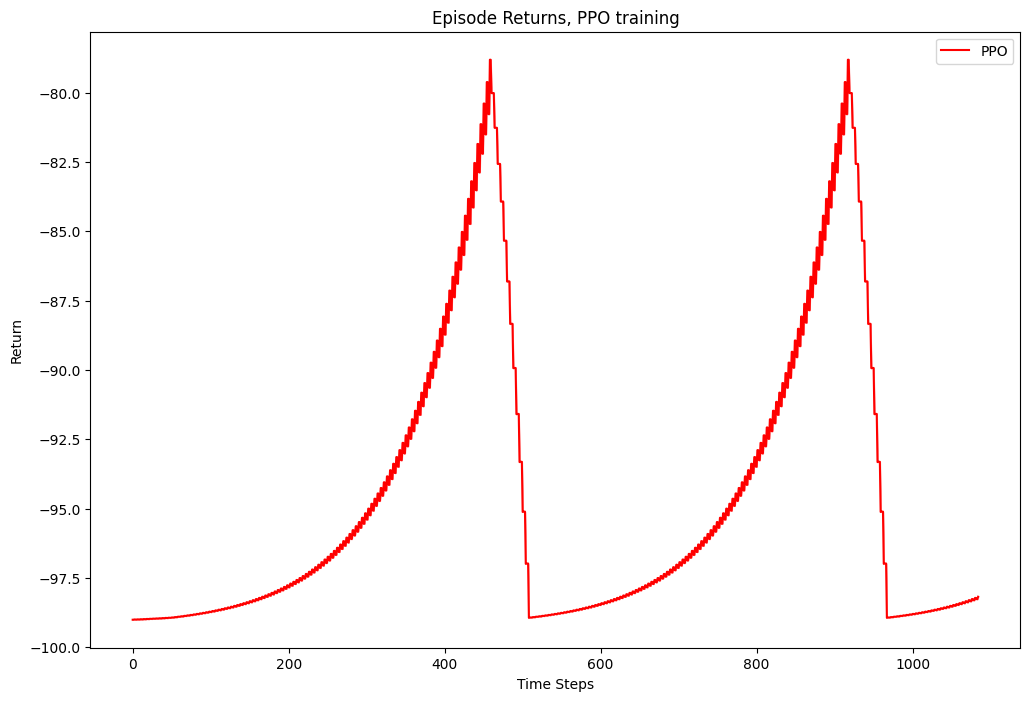

(averages - arr_err).shape=(272,)


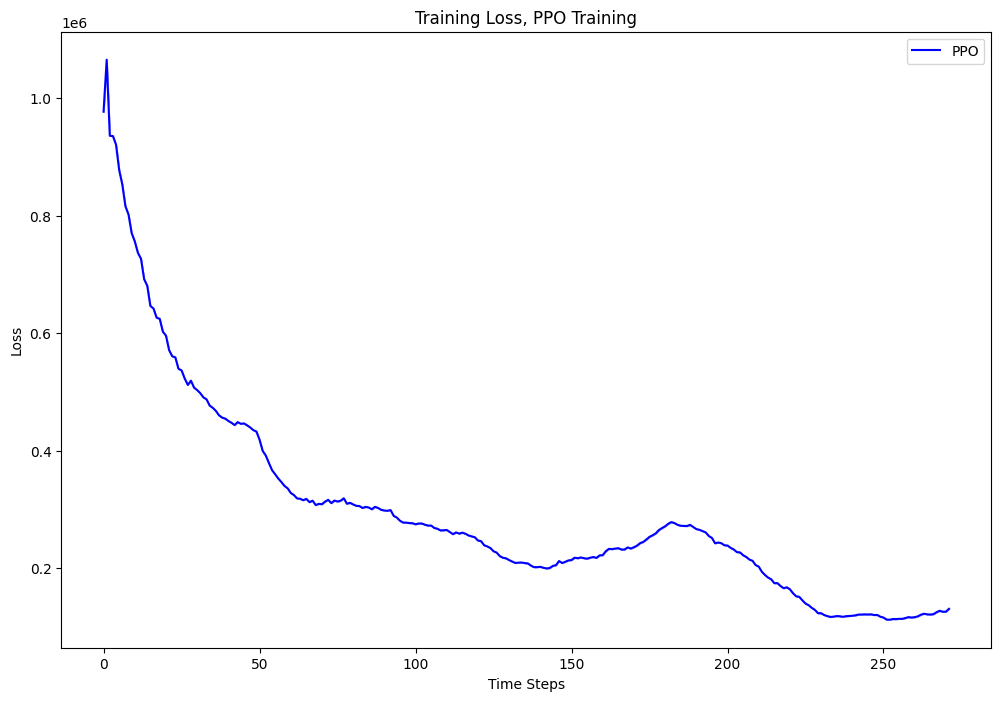

In [14]:
plot_curves([np.array(ppo_returns)], ['PPO'], ['r'], 'Return', 'Episode Returns, PPO training', smoothing = True)
plot_curves([np.array(ppo_losses)], ['PPO'], ['b'], 'Loss', 'Training Loss, PPO Training', smoothing = True)
# plot_curves([np.array(ppo_actor_grads)],
#             ['Actor'],
#             ['orange'],
#             'Gradient magnitude',
#             'Actor Gradient Magnitudes, PPO Training',
#             smoothing = True)

# plot_curves([np.array(ppo_critic_grads)],
#             ['Critic'],
#             ['purple'],
#             'Gradient magnitude',
#             'Critic Gradient Magnitudes, PPO Training',
#             smoothing = True)

False


In [37]:
# Evaluate policy
if __name__ == '__main__':
    print(isinstance(my_trainer.env.__class__, FourRooms))
    num_test_episodes = 100
    test_returns = my_trainer.run_test(num_test_episodes)

False


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 3x128)

(averages - arr_err).shape=(100,)


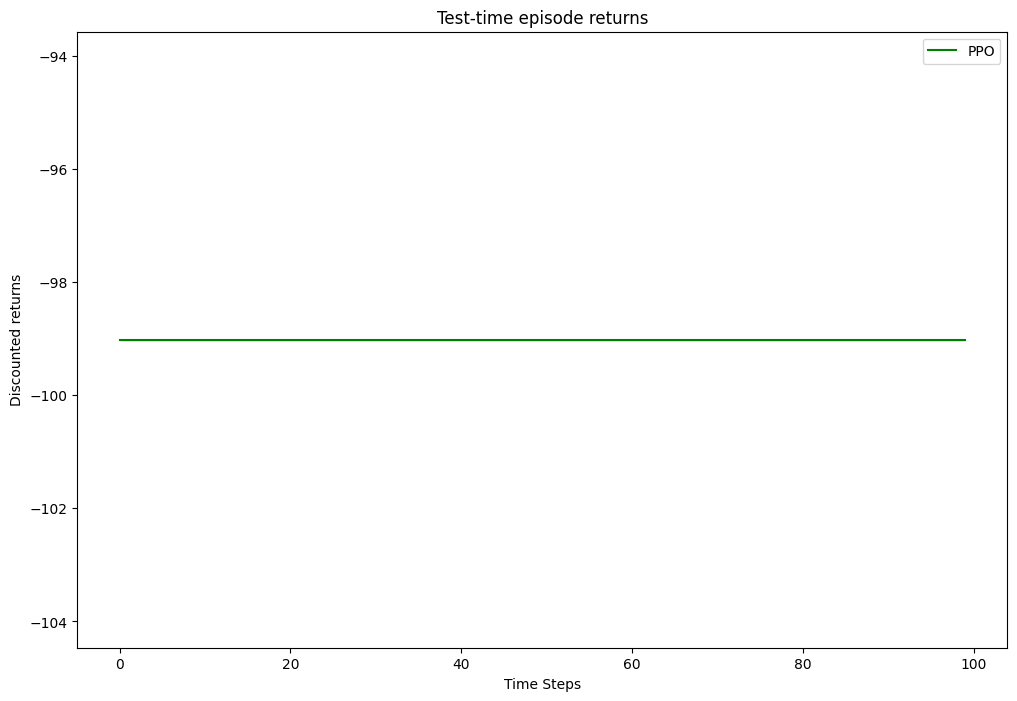

In [18]:
plot_curves([np.array([test_returns])], ['PPO'], ['g'], ylabel='Discounted returns', fig_title='Test-time episode returns', smoothing=False)

## Train PPO on Lunar Lander

ActorCriticNet(
  (critic_in): Linear(in_features=8, out_features=128, bias=True)
  (critic_hidden): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (relu): ReLU()
  (critic_out): Linear(in_features=128, out_features=1, bias=True)
  (actor_in): Linear(in_features=8, out_features=128, bias=True)
  (actor_hidden): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (actor_out): Linear(in_features=128, out_features=4, bias=True)
  (softmax): Softmax(dim=-1)
  (groups): ModuleDict(
    (actor): ModuleList(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): ModuleList(
        (0): Linear(in_features=128, out_features=128, bias=True)
      )
      (2): Linear(in_features=128, out_features=4, bias=True)
    )
    (critic): ModuleList(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): ModuleList(
        (0): Linear(in_features=128, out_features=128, bias=True)
      )
      (2): Linear(in

Episode: 107 | Return: -79.38869599471491 | Moving Avg Return: -80.06507382884125 | Loss: 234.70:  10%|█         | 105/1000 [00:04<00:24, 36.37it/s]  

Episode: 100 | Return: -105.76438760277438 | Moving Avg Return: -81.73239073403168 | Loss: 5162.49
Actor gradient magnitude: 0.012636962463147938
Critic gradient magnitude: 15764.375228881836
----------------------


Episode: 207 | Return: -88.3736007317039 | Moving Avg Return: -74.12809575479334 | Loss: 60.52:  20%|██        | 205/1000 [00:09<00:42, 18.69it/s]     

Episode: 200 | Return: -82.29709114264716 | Moving Avg Return: -73.15095496052764 | Loss: 86.23
Actor gradient magnitude: 1.1870013733863635e-11
Critic gradient magnitude: 762.7777948379517
----------------------


Episode: 306 | Return: -99.4388541355211 | Moving Avg Return: -78.17014117825052 | Loss: 613.87:  30%|███       | 304/1000 [00:12<00:18, 37.53it/s]    

Episode: 300 | Return: -82.91216430849788 | Moving Avg Return: -79.03021677033321 | Loss: 143.22
Actor gradient magnitude: 1.0514052146276542e-09
Critic gradient magnitude: 2418.761667251587
----------------------


Episode: 404 | Return: -105.5324659568443 | Moving Avg Return: -81.98551126121514 | Loss: 370.64:  40%|████      | 403/1000 [00:14<00:18, 32.42it/s]  

Episode: 400 | Return: -86.29280636976075 | Moving Avg Return: -83.02502772346028 | Loss: 16.78
Actor gradient magnitude: 4.178244195074399e-08
Critic gradient magnitude: 406.36248326301575
----------------------


Episode: 508 | Return: -64.77549263283657 | Moving Avg Return: -82.2416548679743 | Loss: 342.10:  51%|█████     | 508/1000 [00:17<00:12, 38.66it/s]    

Episode: 500 | Return: -94.69040209098928 | Moving Avg Return: -80.66288320012944 | Loss: 133.78
Actor gradient magnitude: 1.3017151362534742e-15
Critic gradient magnitude: 3223.2841091156006
----------------------


Episode: 607 | Return: -53.81263219830597 | Moving Avg Return: -71.8225259224875 | Loss: 85.99:  61%|██████    | 607/1000 [00:20<00:10, 37.95it/s]    

Episode: 600 | Return: -75.61222303094866 | Moving Avg Return: -76.42483474454036 | Loss: 1109.55
Actor gradient magnitude: 2.2448924663631686e-09
Critic gradient magnitude: 5309.546913146973
----------------------


Episode: 706 | Return: -82.8431480754128 | Moving Avg Return: -78.48315209159281 | Loss: 107.10:  71%|███████   | 706/1000 [00:22<00:08, 36.29it/s]   

Episode: 700 | Return: -86.98950444378856 | Moving Avg Return: -78.48073109703793 | Loss: 28.52
Actor gradient magnitude: 5.73031758243719e-16
Critic gradient magnitude: 926.8940782546997
----------------------


Episode: 808 | Return: -74.1235112429273 | Moving Avg Return: -79.52378271583925 | Loss: 46.83:  81%|████████  | 809/1000 [00:25<00:04, 38.81it/s]    

Episode: 800 | Return: -87.15992544307892 | Moving Avg Return: -75.19868113201477 | Loss: 159.63
Actor gradient magnitude: 5.654927743847793e-07
Critic gradient magnitude: 2705.5050296783447
----------------------


Episode: 906 | Return: -5.874243930427664 | Moving Avg Return: -77.11156782032201 | Loss: 6973.62:  91%|█████████ | 906/1000 [00:28<00:03, 24.67it/s] 

Episode: 900 | Return: -22.503903185910193 | Moving Avg Return: -75.44203256083479 | Loss: 1236.25
Actor gradient magnitude: 5.664241113905594e-11
Critic gradient magnitude: 3983.994773864746
----------------------


Episode: 999 | Return: -105.37232947233284 | Moving Avg Return: -82.26554681813951 | Loss: 534.30: 100%|██████████| 1000/1000 [00:31<00:00, 31.58it/s]


dict_keys(['ep_lengths', 'actor_grad_mag', 'critic_grad_mag', 'actor_loss', 'critic_loss', 'episode_returns'])
(averages - arr_err).shape=(1000,)


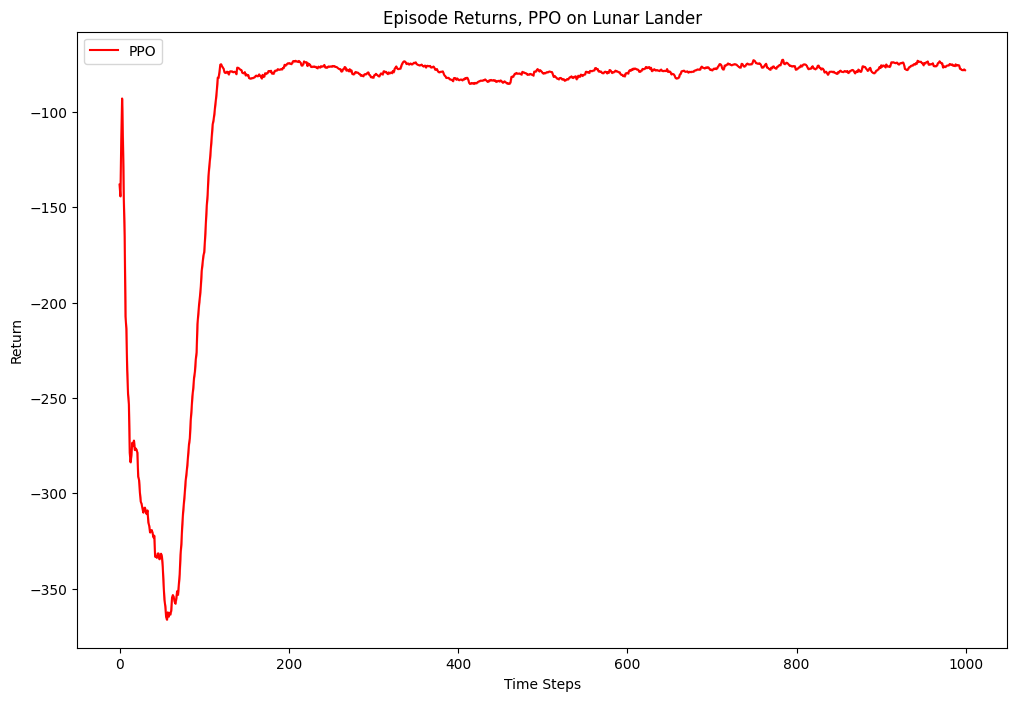

(averages - arr_err).shape=(1000,)


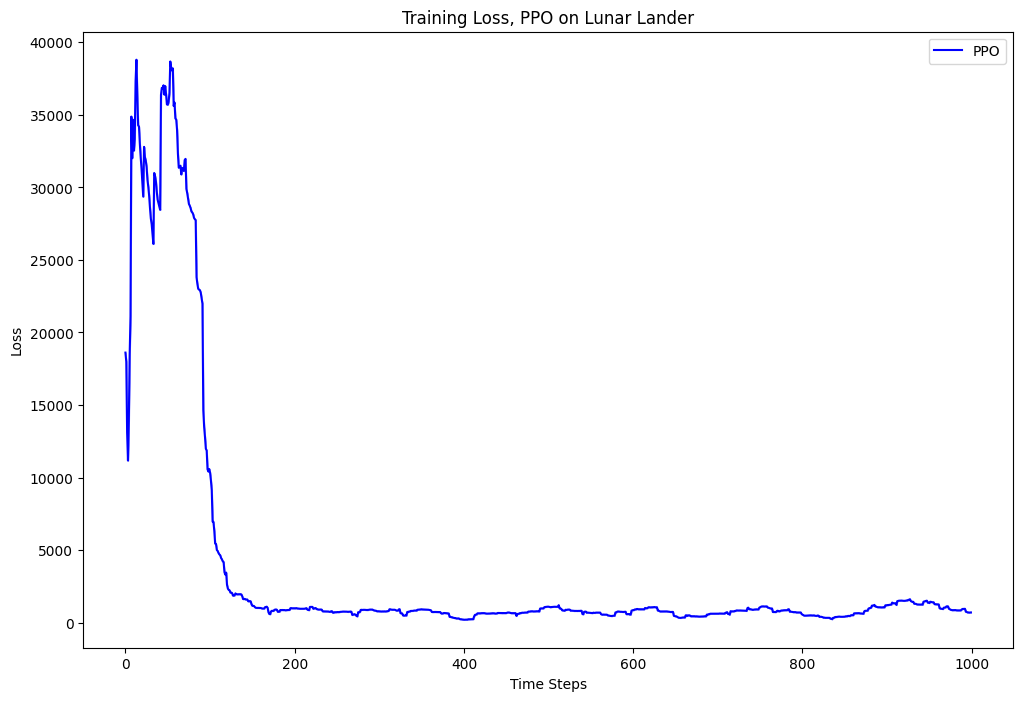

In [45]:
def train_lunar():
    lunar_env = gym.make('LunarLander-v3')

    train_params = {
        'state_size': 8,
        'num_episodes': 1000,
        'num_trials': 1,
        'actor_learning_rate': 5e-3, # 3e-4,
        'critic_learning_rate': 5e-3, #1e-3,
        'gamma': 0.99,
        # 'train_timesteps': 300_000, # my_env.max_time_steps * 1000, # 500_000,
        'entropy_coef': 0.01,
        'buffer_size': 10_000,
        # 'batch_size': 256,
        'update_frequency': 1, # 10_000,
        'warmup_period': 10_000,
        'save_filename': './ppo-lunar-lander',
        'model_save_frequency': 250,
        'epsilon': 0.2,
        'epochs_per_update': 5,
        'avg_return_window': 25,
        'log_frequency': 100 # 50_000,
    }

    ppo_returns = []
    ppo_losses = []
    ppo_info = {}

    for _ in range(train_params['num_trials']):
        my_agent = PPOAgent(observation_dim=8, hidden_dim=128, n_hidden=2, action_dim=4) # agent is the same
        print(my_agent.policy_net)
        my_trainer = PPOAgentTrainer(my_agent, lunar_env, train_params)
        returns, losses, info = my_trainer.run_train_simple()

        ppo_returns.append(returns)
        ppo_losses.append(losses)
        for key, val in info.items():
            ppo_info.setdefault(key, [])
            ppo_info[key].append(val)

    return ppo_returns, ppo_losses, ppo_info


train_ret_tuple = train_lunar()
lunar_returns, lunar_losses, lunar_info = train_ret_tuple
print(lunar_info.keys())
plot_curves([np.array(lunar_returns)], ['PPO'], ['r'], 'Return', 'Episode Returns, PPO on Lunar Lander', smoothing = True)
plot_curves([np.array(lunar_losses)], ['PPO'], ['b'], 'Loss', 'Training Loss, PPO on Lunar Lander', smoothing = True)

with open('ppo-lunar.pickle', 'wb') as handle:
    pickle.dump(train_ret_tuple, handle, protocol=pickle.HIGHEST_PROTOCOL)